In [10]:
# authors: nmg, pbg
# phy5905 sp22
# project 2

# import packages
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

## Physics

Reference: [MIT 8.01 lecture notes](http://web.mit.edu/8.01t/www/materials/Presentations/old_files_f07/Presentation_W14D1.pdf) 

Two-body framework:
* $\overrightarrow{r_1}$: distance from origin to $M_1$ 
* $\overrightarrow{r_2}$: distance from origin to $M_2$
* $\overrightarrow{r}_{CM} = \frac{m_1\overrightarrow{r_1} + m_2\overrightarrow{r_2}}{m_1 + m_2} $
  * $\overrightarrow{r}_{CM}$: distance from origin to center of mass
* $ \mu = \frac{m_1 m_2}{m_1 + m_2}$, reduced mass
* $\overrightarrow{r}$: distance between $M_1$ and $M_2$ 
  * $\overrightarrow{r} = \overrightarrow{r_1} - \overrightarrow{r_2}$
  
We can also get the vectors from the center of mass to $M_1$ and $M_2$:
$$ \overrightarrow{r_1}'  = \overrightarrow{r_1} - \overrightarrow{r_{CM}}$$
$$ \overrightarrow{r_1}'  = \overrightarrow{r_1} - \frac{m_1\overrightarrow{r_1} 
+ m_2\overrightarrow{r_2}}{m_1 + m_2}  $$
$$ \overrightarrow{r_1}'  = \frac{m_2 (\overrightarrow{r_1} - \overrightarrow{r_2})}{m_1 + m_2} $$

We now have expressions for the position vector of each mass with respect to
the center of mass:
* $ \overrightarrow{r_1}' = \frac{\mu}{m_1}\overrightarrow{r}$
* $ \overrightarrow{r_2}' = \frac{\mu}{m_2}\overrightarrow{r}$

By rewriting the two-body problem to a single-body, reduced-mass problem, we 
have an expression for $\overrightarrow{r}$:
$$ \overrightarrow{r_0} = \frac{p}{1 + e cos(\phi)} $$

We also can express the angle between each mass and the semimajor axis or axis
of closest approach as $\phi$:
$$ \phi_{0} = \phi_{0,1} = -\phi_{0,2} $$

We can use this expression $r(\phi)$ to find initial values for $ \overrightarrow{r_1}'$ 
and $ \overrightarrow{r_2}'$, and then express these in Cartesian coordinates.

Here are the expressions for $m_1$: 
* $ x_{0,1} = r_{0,1}' cos \phi_{0,1} $
* $y_{0,1} = r_{0,1}' sin \phi_{0,1} $
* $\dot{x_{0,1}} = -r_{0,1}'sin \phi_{0,1} \dot{\phi_{0,1}} + \dot{r_{0,1}}' cos \phi_{0,1}$
* $ \dot{y_{0,1}} = r_{0,1}' cos \phi_{0,1} \dot{\phi_{0,1}} + \dot{r_{0,1}}' sin \phi_{0,1}$

  


## Computation

Reference: [A Simple Leapfrog Integration Scheme to Find Optimal Interplanetary Trajectories by Scott M. Kelley](https://ir.library.oregonstate.edu/downloads/cc08hm643)

The basic equations of motion of the leapfrog integration scheme are

$$r_{i+1} = r_i + v_{i+\frac{1}{2}} \Delta t \\
v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t. $$

This system of equations can be rewritten without the explicit use of half-steps by first
expressing the velocity term for a full step in two distinct half-steps

$$v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t \\
v_{i+1} = v_{i+\frac{1}{2}} + \frac{a_{i+1}}{2} \Delta t. $$

Combining above equations allows the equations of motion to be written strictly in terms of integer timesteps:

$$r_{i+1} = r_i + v_i \Delta t + \frac{a_i}{2}\Delta t^2 \\
v_{i+1} = v_i + \frac{(a_i + a_{i+1})}{2} \Delta t $$

In [11]:
def f2(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration 'a'
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)
    

In [12]:
def get_energy(r, vi):
    """
    Calculate vis-viva energy for two masses
    
    Inputs:
        r, 1-D array of (x1, y1, x2, y2)
        vi, 1-D array of (vx1, vy1, vx2, vy2)
    Returns:
        energy, v**2/2 - mu/r
    
    """
    
    x1, y1, x2, y2 = r
    vx1, vy1, vx2, vy2 = vi
    
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    v12 = np.sqrt((vx2 - vx1)**2 + (vy2 - vy1)**2)
    
    vve = 0.5*v12**2 - mu/r12
    E = 0.5*mu*v12**2 - G*m1*m2/r12
    
    return E
    

In [13]:
def get_err(truth, computed):
    """Calculate relative error"""
    if truth == 0.:
        print("using alt err")
        err = truth - computed
    else: 
        err = (truth - computed)/truth
    return err

In [14]:
def leapfrog(t0, tmax, r0, phi0, dphi0, dr0, h, f, err_tol, plot=False, **kwargs):
    """                                                                                                                      
    Calculate a soln r(t) to a 1st-order ODE of the form r'(t)=f(r,t).                                                 
                                                                                                                             
    Uses the leapfrog method.    
    
    Inputs: 
    t0 & tmax (Init & final time) 
    r0, phi0 (Init pos, angle of reduced mass, mu)
    dphi0, dr0 (initial angular, radial velocity of mu)
    h (step size)
    f (function to obtain accelaration)
    err_tol: amount of allowed error in Energy calculation
    
    Returns: 
    t (array for time steps)
    X & Y (arrays for position coordinates of both objects wrt COM)
    v_ (array of velocities of both objects)
    err (array for relative err in position)
    
    """
    
    debug = False
    
    x0 = r0 * np.cos(phi0)
    y0 = r0 * np.sin(phi0)
    vx0 = -r0 * np.sin(phi0)*dphi0 + np.cos(phi0)*dr0
    vy0 = r0 * np.cos(phi0)*dphi0 + np.sin(phi0)*dr0
    
    # convert from one-body reduced-mass to two-body problem
    x1, y1 = (mu/m1)*x0, (mu/m1)*y0  # r0, 0
    x2, y2 = -(mu / m2)*x0, -(mu / m2)*y0 # -q*r0,0
    vx1, vy1 = (mu/m1)*vx0, (mu/m1)*vy0 # 0, v0
    vx2, vy2 = -(mu / m2)*vx0, -(mu / m2)*vy0 # 0,-q*v0
    
    # Initialize array for time at each step
    ti = t0
    t = np.array(ti)
    
    # initialize arrays of positions at each step
    r = np.array([x1, y1, x2, y2], float)
    R = np.array([r])
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    v_ = np.array([vinit]) 
    vi = vinit
    
    # track relative error between initial Energy, calculated Energy 
    E_now = get_energy(r,vi)
    # total energy of system, E = KE + PE
    E_ref = 0.5*mu*(vx0**2 + vy0**2) - G*m1*m2/r0
    
    rel_err = get_err(E_ref, E_now)
    #print(f"t=0: E_ref: {E_ref}, rel_err: {rel_err}")
    err = np.array([rel_err])
    E = np.array([E_now])
    
    # solve eqns of motion using leapfrog method
    while True: # np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # update t, r, v_mid
            ti += h
            ri = r +  h*vi + 0.5*f(r)*h**2
            vi = vi + 0.5*h*(f(r) + f(ri))
            r = ri
            Ei = get_energy(r, vi)
            
            # calculate new rel error
            # print(f"dE: {E_ref - get_energy(r, vi)}")
            rel_err = get_err(E_ref, get_energy(r, vi))
            #print(f"err: {rel_err}")
            
            # save t, r, phi_mid
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            v_ = np.append(v_, np.array([vi]), axis=0)
            err = np.append(err, rel_err) # relative error
            E = np.append(E, Ei)
    
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    # calculate error using either relative error or mean of E 
    print(f"E_ref = {E_ref}, |mean(E)| = {np.abs(np.mean(E))}")
    #err = (E_ref - E) / np.max((np.abs(E_ref), np.abs(np.mean(E))))
    #err = (E - E_ref) / (E_ref, d)
    
    if plot == True:
        make_plot(X, Y, v_, t, err)
    
    return t, R, X, Y, v_, err

In [15]:
def make_plot(X, Y, v_, t, err):
    fig = plt.figure(figsize=(12,10))


    # paths of m1, m2
    plt.subplot(221) # ,aspect='auto')
    plt.scatter(0,0, marker='x', color='grey', alpha=0.5, label=r'CoM')
    plt.scatter(X[0,0], Y[0,0], s=10, c='steelblue') # initial position
    plt.scatter(X[0,1], Y[0,1], s=10, c='orange') # initial position
    plt.plot(X[:,0], Y[:,0], label=f"m1 = {m1:.3} Msun")
    plt.plot(X[:,1], Y[:,1], label=f"m2 = {m2:.3} Msun")
    plt.xlabel("x [kpc]", fontsize=12), plt.ylabel("y [kpc]", fontsize=12)
    plt.legend(loc='lower right')
    plt.title("Orbits of galaxies", fontsize='15', y=1.05)

    # err vs time
    plt.subplot(222,aspect='auto')
    plt.scatter(t, err, s=1)
    plt.ylim(err_tol*np.array([-1,1]))
    plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Relative error", fontsize=12)
    plt.title("Relative err in position vs. time" , fontsize='15', y=1.05)
    print(f"cumulative error over {t[-1]} Myr: {err[-1]:.6} .")

    # vx vs vy
    plt.subplot(223,aspect='auto')
    plt.scatter(0,0, marker='x', color='grey', label=r'$v_{CoM}$')
    plt.scatter(v_[0,0], v_[0,1], s=10, c='steelblue') # initial velocity
    plt.scatter(v_[0,2], v_[0,3], s=10, c='orange') # initial velocity
    plt.plot(v_[:,0], v_[:,1], label="m1")
    plt.plot(v_[:,2], v_[:,3], label="m2")
    plt.title("Motion of galaxies in 2D", fontsize='15', y=1.01)
    plt.legend()
    plt.xlabel("$v_{x}$", fontsize=12), plt.ylabel("$v_y$", fontsize=12)

    # vel vs time
    plt.subplot(224,aspect='auto')
    plt.plot(t, np.sqrt(v_[:,0]**2 + v_[:,1]**2), lw=3, label="m1" )
    plt.plot(t, np.sqrt(v_[:,2]**2 + v_[:,3]**2), label="m2" )
    plt.title("Velocities of galaxies vs. Time", fontsize='15', y=1.05)
    plt.legend()
    plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Velocity", fontsize=12)


    fig.suptitle("\nSimulating orbits using Leapfrog Method\n", fontsize = '20')
    fig.subplots_adjust(hspace=0.3,wspace=0.3,top=0.85,bottom=0.05)
    plt.show()
    
    
    plt.scatter(0,0, marker='x', color='grey', alpha=0.5, label=r'CoM')
    plt.scatter(X[0,0], Y[0,0], s=20, c='steelblue') # initial position
    plt.scatter(X[0,1], Y[0,1], s=20, c='orange') # initial position
    plt.plot(X[:,0], Y[:,0], label=f"m1 = {m1:.3} Msun")
    plt.plot(X[:,1], Y[:,1], label=f"m2 = {m2:.3} Msun")

    plt.xlabel("x [kpc]"), plt.ylabel("y [kpc]")
    plt.legend()
    plt.title("Orbits of galaxies", fontsize='15', y=1.05)
    plt.show()


In [16]:
def test_particles():
    '''Function returns the position of test particles w.rt. center of galaxy #1.
    
    Returns:
    particles 
    (1st rows of this array gives position of galaxy wrt COM)
    (subsequent rows gives position of stars wrt COM)
    
    '''
    ring_spacing = np.array([0.2, 0.3, 0.4, 0.5, 0.6]) 
    # np.array([0.12, 0.18, 0.24, 0.3, 0.36]) # alt ring spacing

    n_particles = np.array([12,18,24,30,36]) # number of particles per ring
    global tot_stars
    tot_stars = np.sum(n_particles)
    
    # initial position, velocity of galaxy wrt center of mass
    x0 = r0 * np.cos(phi0)
    y0 = r0 * np.sin(phi0)
    vx0 = -r0 * np.sin(phi0)*dphi0 + np.cos(phi0)*dr0
    vy0 = r0 * np.cos(phi0)*dphi0 + np.sin(phi0)*dr0
    x1, y1 = (mu/m1)*x0, (mu/m1)*y0  # r0, 0
    vx1, vy1 = (mu/m1)*vx0, (mu/m1)*vy0 # 0, v0
    gx0, gy0 = x1, y1
    gvx0, gvy0 = vx1, vy1
    galaxy_coords = np.array([gx0, gy0, gvx0, gvy0])
    
    
    rings_r = ring_spacing*rmin  # radius of each ring from center of galaxy
    #rings_r += r0 # radius of each ring from COM of two galaxies
    rings_phi = 2*np.pi / n_particles  # angular position of each particle
    
    particles = np.array([galaxy_coords])
    #particles = np.array([])
    particles = particles.reshape(1,4)

    # make evenly spaced rings of N particles per ring
    for i in range(len(rings_r)):
        # r, phi coordinates for each particle
        phis = np.arange(0,2*np.pi,rings_phi[i])
        rs = np.ones(n_particles[i]) * rings_r[i]

        # convert to cartesian coordinates
        xs = rs * np.cos(phis) + x1   # xstar wrt com
        ys = rs * np.sin(phis) + y1   # ystar wrt com
        vxs = np.zeros(len(xs)) + vx1 # vxstar wrt com
        vys = np.zeros(len(xs)) + vy1 # vystar wrt com

        # add row of x, y, vx, vy for each particle in ring
        ring_particles = np.concatenate(np.array([list(zip(xs, ys, vxs, vys))]),axis=0)
        particles = np.append(particles, ring_particles, axis=0)
        
    return particles


In [17]:
def f3(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector of a star in 2D.
    
    Inputs:  
    rs:  [x_star, y_star, x_galaxy1, y_galaxy1, x_galaxy2, y_galaxy2]
    array with x-, y- components of pos of star, galaxy1, galaxy2 respectively
    Returns: array of x-,y- components of acceleration of a star
             evaluated at these points
    """
    # position of mass1, mass2    
    x_star, y_star = rs[0], rs[1] # pos of star wrt COM
    x2, y2 = rs[2], rs[3] # galaxy #1 wrt COM
    x3, y3 = rs[4], rs[5] # galaxy #2 wrt COM
    r12 = np.sqrt((x2 - x_star)**2 + (y2 - y_star)**2)
    r13 = np.sqrt((x3 - x_star)**2 + (y3 - y_star)**2)
#     r12 = np.sqrt((x_star)**2 + (y_star)**2)
#     r13 = np.sqrt((x_star)**2 + (y_star)**2)

    # x, y components of Acceleration 'a'
    ax = G*m1*(x2 - x_star)/r12**3  + G*m2*(x3 - x_star)/r13**3 
    ay = G*m1*(y2 - y_star)/r12**3  + G*m2*(y3 - y_star)/r13**3    
#     ax = G*m1*(x_star)/r12**3  + G*m2*(x_star)/r13**3 
#     ay = G*m1*(y_star)/r12**3  + G*m2*(y_star)/r13**3    
    
    return np.array([ax, ay], float)

In [18]:
# Obtain a circular disk of galaxy containing massless test particles 
##   pretended as stars

def evolve_disk_galaxy2():
    '''
    Evolves the disk of galaxy #1 with galaxy #2
    using leapfrog integration.
    
    '''
    
    #ts = np.arange(t0+h, tmax+h, h)
    
    particles = test_particles() # obtain initial position and velocities of stars  around galaxy#1
    plt.scatter(particles[:, 0], particles[:,1])
    
    # Start 3-D array to store [x,y,vx,vy] of stars
    elements = tot_stars* len(ts)*4
    arr_star = np.zeros(elements).reshape(tot_stars, len(ts), 4)
    
    # update [x,y,vx,vy] in the 3-D array of stars for 0th time step
    for  k in np.arange(1, len(particles)): #skipping first row of galaxy
        pos = particles[k][:2] #[x*, y*]
        vel = particles[k][2:]
        xs, ys = pos[0], pos[1]
        vxs, vys = vel[0], vel[1]

        arr_star[k-1][0] = np.array([xs, ys, vxs, vys])
        
    #---------------------------------------------------------------------------------------    
    # Iterations for LEAPFROG Integrations
    for  k in np.arange(0, len(particles)-1,1):#skipping first row of galaxy
        # get initial pos and vel of star
        pos = arr_star[k][0][:2]  #[x*, y*] for k^th particle at prev time step
        vel = arr_star[k][0][2:] #[vx*,vy*]
        xs, ys = pos[0], pos[1]
        vxs, vys = vel[0], vel[1]
        
        for step in np.arange(1, len(ts),1): 
            gx1, gy1 = R_galaxy[step-1][0], R_galaxy[step-1][1]
            gx2, gy2 = R_galaxy[step-1][2], R_galaxy[step-1][3]
            vx1, vy1 = V_galaxy[step][0], V_galaxy[step][1]
            #pepare input arrays for acceleration function 'f3'
            r_old = [xs, ys, gx1, gy1, gx2, gy2]
        
            # update pos of stars
            #ri = pos + h*vel + 0.5*(f3(r_old) + f2(R_galaxy[step-1])[:2])*h**2 # + np.array([gx1,gy1])
            ri = pos + h*vel + 0.5*(f3(r_old))*h**2  #+ np.array([gx1,gy1])
            
            #pepare input arrays for acceleration function 'f3'
            gx1_next, gy1_next = R_galaxy[step][0], R_galaxy[step][1]
            gx2_next, gy2_next = R_galaxy[step][2], R_galaxy[step][3]
            r_new = [ri[0], ri[1], gx1_next, gy1_next, gx2_next, gy2_next]
            
            # update vel of stars
            #vi = vel + 0.5*h*(f3(r_old)+ f2(R_galaxy[step-1])[:2] + f3(r_new) + f2(R_galaxy[step])[:2]) # + np.array([vx1, vy1])
            vi = vel + 0.5*h*(f3(r_old) + f3(r_new)) #+ np.array([vx1, vy1])

            # Add the pos, vel of current time step in 3-D array
            arr_star[k][step] = np.array([ri[0], ri[1], vi[0], vi[1]])
            
            
            # get ready for new time step
            pos = ri
            vel = vi
            xs, ys = pos[0], pos[1]
            vxs, vys = vel[0],vel[1]
    #prin

    return arr_star

In [19]:
# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# tunable orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
rmin = 25. # kpc #for parabolic encounter
a = rmin # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
ecc = 1. # eccentricity

# Etot = -Gm1m2/2a (total energy)
# PE_12 + KE_1 + KE_2 = Etot
# -Gm1m2/r_12 + 0.5*m1*v1**2 + 0.5*m2+v2**2 = Etot
# a = 100 # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
# ecc = 0.1 #1e-12 #0.05 
# p = a*(1 - ecc**2)   # semi-latus rectum (kpc)
# calculated parameters
M = m1 + m2
mu = m1*m2 / M
P = np.sqrt((4*np.pi**2*a**3)/(G*M))

# runtime initial conditions
t0, tmax = 0, 700 #5*P # 5000
print(f"runtime {tmax} Myr")
h = 100 #1e-3  # Myr

# define values for p, error calculation
if ecc == 1.:      # parabolic orbit
    print("parabolic orbit")
    p = 2 * rmin  
    err_tol = 1e10  # arbitrary value because E = 0
elif (ecc > 0.) & (ecc < 1.): # closed orbit, elliptical
    print("elliptical orbit")
    p = a * (1 - ecc**2)
    err_tol = 1e-5
else: # closed orbit, circular
    print("circular orbit")
    p = a
    err_tol = 1e-5

# choose initial position, motion of reduced-mass galaxy pair relative to 
#    semi-major axis or axis of closest approach
phi0 = np.pi*(2*np.random.rand() - 1) 
r0 = p / (1 + ecc * np.cos(phi0))
dphi0 = np.sqrt(G*M*p) / r0**2
dr0 = ecc * r0**2 * np.sin(phi0) * dphi0 / p

print(f"initial r0, phi0: {r0:.5} kpc, {phi0:.5} rad")

runtime 700 Myr
parabolic orbit
initial r0, phi0: 123.73 kpc, -2.2092 rad


In [20]:
# leapfrog(t0, tmax, r0, v0, h, f, r_ref, err_tol, **kwargs)
ts, R_galaxy,  X, Y, V_galaxy, err =  leapfrog(t0, tmax, r0, phi0, dphi0, dr0, h, f2, err_tol, plot = False)


using alt err
using alt err
using alt err
using alt err
using alt err
using alt err
using alt err
using alt err
using alt err
E_ref = 0.0, |mean(E)| = 7784835613.54825


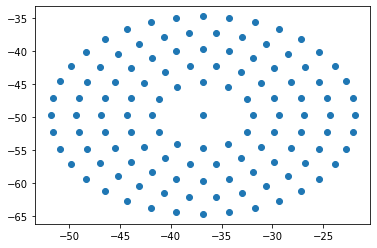

In [21]:
arr_star = evolve_disk_galaxy2()


In [22]:
X_star = arr_star[:,:,0]
Y_star = arr_star[:,:,1]
Vx_star = arr_star[:,:,2]
Vy_star = arr_star[:,:,3]

(-2000.0, 2000.0)

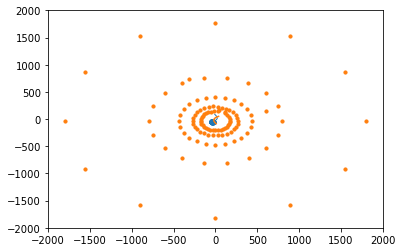

In [23]:
end = len(ts)-1 # 100 Myr = 10^8 yrs
plt.plot(R_galaxy[:,0],R_galaxy[:,1], lw=1)       # gal1
plt.plot(R_galaxy[:,2],R_galaxy[:,3])         # gal2
plt.scatter(X_star[:,0], Y_star[:,0], s=10)    # initial stars position
plt.scatter(X_star[:,2], Y_star[:,2], s=10)
#plt.scatter(X_star[:,-1], Y_star[:,-1], s=10) # position at "end"
#plt.scatter(R_galaxy[1,0],R_galaxy[1,1], s=100)
#plt.scatter(X_star[:,100], Y_star[:,100], s=2)
window = 2000
plt.xlim([-window,window])
plt.ylim([-window,window])
#plt.scatter(X_star[:,101], Y_star[:,101], s=2)
# plt.scatter(X_star[:,300], Y_star[:,300], s=2)
# plt.scatter(X_star[:,400], Y_star[:,400], s=2)

In [24]:
np.savetxt('stars_posX.txt',np.array(X_star), fmt='%f')
np.savetxt('stars_posY.txt',np.array(Y_star), fmt='%f')
np.savetxt('stars_velX.txt',np.array(Vx_star), fmt='%f')
np.savetxt('stars_velY.txt',np.array(Vy_star), fmt='%f')


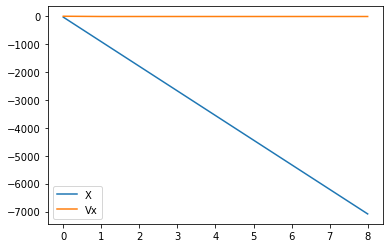

In [25]:
#plt.plot(Vy_star[0,:10])
end = 20
plt.plot(X_star[0,:end], label='X')
plt.plot(Vx_star[0,:end], label='Vx')
plt.legend()

In [17]:

#plt.plot(Y_star[0,:8])

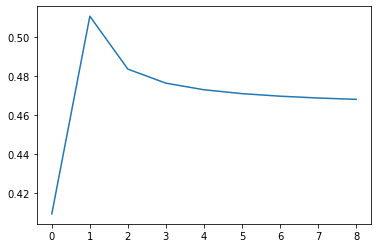

In [18]:
plt.plot(V_galaxy[:,1])

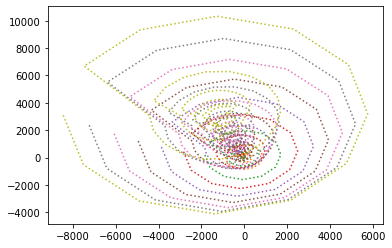

In [19]:
plt.plot()
plt.plot(X_star, Y_star, ":")
plt.show()

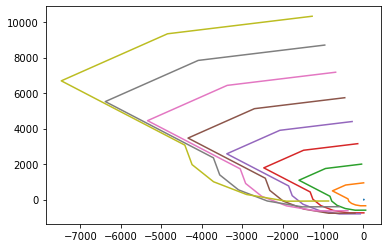

In [20]:
plt.plot(X_star[len(ts):2*len(ts)], Y_star[len(ts):2*len(ts)]);

9


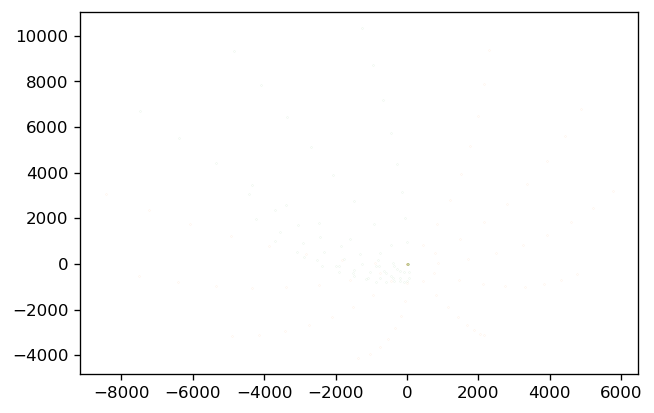

In [21]:
n_particles = np.array([12,18,24,30,36])
idx = 0
print(len(ts))
k=0
fig = plt.figure(figsize=(6, 4), dpi=120)     
for n in n_particles:
    p = 0
    for k in np.arange(p,p+n):
   # plt.scatter(X_star[idx:idx/n+len(ts)], Y_star[idx:idx/n+len(ts)], s=0.03, marker='o')#, ":", label=f'{n}')
        plt.scatter(X_star[idx:k*len(ts)], Y_star[idx:k*len(ts)],s = 0.001, marker='o')
    
        idx = idx + k*len(ts)
    p = p+n

In [22]:
arr = np.arange(1,25).reshape(2,3,4)
print(arr)

print(arr[:,:,0].reshape(-1))


[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]]

 [[13 14 15 16]
  [17 18 19 20]
  [21 22 23 24]]]
[ 1  5  9 13 17 21]


In [23]:
        # update velocities of stars
#         vx_star += vx_star + 0.5*h*(G*(m1*(x1-x_star)/r1**3 + m2*(x2-x_star)/r2**3)
#                                     +  0.5*h*(G*(m1*(x1-x_star)/r1**3 + m2*(x2-x_star)/r2**3)
#         vy_star += vy_star + 0.5*h*(G*(m1*(y1-y_star)/r1**3 + m2*(y2-y_star)/r2**3) 
#                                     + 0.5*h*(G*(m1*(y1-y_star)/r1**3 + m2*(y2-y_star)/r2**3)

In [24]:
# # Obtain a circular disk of galaxy containing massless test particles 
# ##   pretended as stars

# def evolve_disk_galaxy2(h, Nsteps=1000, Nsnapshots =100):
#     '''
#     Evolves the disk of galaxy #1 with galaxy #2
#     using leapfrog integration.
    
#     '''
    
#     ts = np.arange(t0+h, tmax+h, h)
    
#     x0 = r0 * np.cos(phi0)
#     y0 = r0 * np.sin(phi0)
#     vx0 = -r0 * np.sin(phi0)*dphi0 + np.cos(phi0)*dr0
#     vy0 = r0 * np.cos(phi0)*dphi0 + np.sin(phi0)*dr0
    
#     # convert from one-body reduced-mass to two-body problem
#     # Initial pos & vel of both galaxies wrt COM
#     x1, y1 = (mu/m1)*x0, (mu/m1)*y0  # r0, 0
#     x2, y2 = -(mu / m2)*x0, -(mu / m2)*y0 # -q*r0,0
#     vx1, vy1 = (mu/m1)*vx0, (mu/m1)*vy0 # 0, v0
#     vx2, vy2 = -(mu / m2)*vx0, -(mu / m2)*vy0 # 0,-q*v0
    
#     r_g = np.array([x1, y1, x2, y2], float)
#     R_galaxy = np.array([r_g])
    
#     vi_g = np.array([vx1, vy1, vx2, vy2], float)
#     V_galaxy  = np.array([vi_g]) 
    
#     # number of steps per snapshot
#     div = max(int(N_steps/N_snapshots), 1)
#     print("\nSolving equations of motion for a galaxy interacting with disk of galaxy with stars using Leapfrog integration\n")
    
#     particles = test_particles() # obtain initial position and velocities of stars  around galaxy#1
#     x_star = particles[:,0]
#     y_star = particles[:,1]
#     vx_star = particles[:,2]
#     vy_star = particles[:,3]

    
#     rs = [x_star, y_star, x1, y1, x2, y2]
#     vi_ = [vx_star, vy_star, vx1, vy1, vx2, vy2]
    
#     # Start 3-D array to store [x,y,vx,vy] of stars
#     elements = tot_stars* len(ts)*4
#     arr_star = np.zeros(elements).reshape(tot_stars, len(ts), 4)
    
    
#     # update [x,y,vx,vy] of stars for 0th and 1st time step
#     for  k in np.arange(1, len(particles)+1,1): #skipping first row of galaxy
#         pos = particles[k][:2] #[x*, y*]
#         vel = particles[k][2:]
#         xs, ys = pos[0], pos[1]
#         vxs, vys = vel[0], vel[1]
        
#         #pepare input arrays for acceleration function 'f3'
#         rs = [xs, ys, r_g[0], r_g[1],r_g[2], r_g[3]]
#         ris = [xs, ys, ri_g[0], ri_g[1],ri_g[2], ri_g[3]]

#         # update pos and vel of stars
#         ri_s = pos + h*vel + 0.5*f(rs)*h**2
#         vi_s = vel + 0.5*h*(f(rs) + f(ris))
        
#         arr_star[k][0] = np.array([xs, ys, vxs, vys])
#         arr_star[k][1] = np.array([ri_s[0], ri_s[0], vi_s[0], vi_s[1]])
        
        
#     # Iterations for LEAPFROG Integrations
#     for step in np.arange(2, len(ts),1):
        
#         # update the galaxies
#         ri_g = r_g +  h*vi_g + 0.5*f2(r_g)*h**2
#         vi_g = vi_g + 0.5*h*(f(r_g) + f(ri_g))
        
            
#         for  k in np.arange(1, len(particles)+1,1): #skipping first row of galaxy
#             pos = arr_star[k][step-1][:2]  #[x*, y*] for k^th particle at prev time step
#             vel = particles[k][step-1][2:] #[vx*,vy*]
#             xs, ys = pos[0], pos[1]
#             vxs, vys = vel[0], vel[1]
#             #pepare input arrays for acceleration function 'f3'
#             rs = [xs, ys, r_g[0], r_g[1],r_g[2], r_g[3]]
#             ris = [xs, ys, ri_g[0], ri_g[1],ri_g[2], ri_g[3]]

#             # update pos and vel of stars
#             ri_s = pos + h*vel + 0.5*f(rs)*h**2
#             vi_s = vel + 0.5*h*(f(rs) + f(ris))

#             arr_star[k][0] = np.array([xs, ys, vxs, vys])
#             arr_star[k][1] = np.array([ri_s[0], ri_s[0], vi_s[0], vi_s[1]])
        

       

#         r_g = ri_g
#         Ei = get_energy(r_g, vi_g)
#         rel_err = get_err(E_ref, Ei)
        

#         # save t, r, phi_mid
#         t = np.append(t, ti)
#         R_g = np.append(R_g, np.array([r_g]), axis=0)
#         V_g = np.append(V_g, np.array([vi_g]), axis=0)
#         err = np.append(err, rel_err) # relative error
#         E = np.append(E, Ei)